In [1]:
from GT import get_dataset, denormalize
import matplotlib.pyplot as plt
from GT import GTM
from GT import gmm_loss
import json
import torch
from MMD import mmd_poly, mmd_linear, mmd_rbf
import numpy as np
import os
from tsl.datasets import AirQuality, MetrLA, PemsBay

DATASET_NAME = 'PemsBay'
MODEL_NAME= 'GMM'

# Magic
MODELS_PATH = f'./models'
IMAGES_PATH = f'./PNG'
DEVICE = 'cuda:1' if torch.cuda.is_available() else 'cpu' if torch.backends.mps.is_available() else 'cpu'
torch.set_default_device(DEVICE)

In [2]:
if not os.path.exists(f'{MODELS_PATH}/{DATASET_NAME}/'):
    os.makedirs(f'{MODELS_PATH}/{DATASET_NAME}')
if not os.path.exists(f'{IMAGES_PATH}/{DATASET_NAME}/'):
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/History')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/Train')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/Validation')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/Test')

## Model parameters

In [3]:
# Model Parameters 100 hidden
hidden_size = 32
num_layers = 1
lr = 0.001
weight_decay = 0.001
# weight_decay = 0
dropout = 0
bidirectional = True
mixture_dim = 20
debug = False
train_from_checkpoint = True
dataset = PemsBay()


## Dataset

In [4]:
dataset = dataset.dataframe()[-1000:]

In [5]:
# Dataset Split\
Train, Validation, Test = get_dataset('PemsBay', dataset=dataset)

train_data = Train
train_data = torch.Tensor(train_data)
train_label = train_data
train_data = train_data[:-1]
train_label = train_label[1:]

validation_data = Validation
validation_data = torch.Tensor(validation_data)
validation_label = validation_data
validation_data = validation_data[:-1]
validation_label = validation_label[1:]

input_size = train_data.shape[-1]
output_size = input_size
num_time_steps = len(train_data)

PemsBay DATA
________________________________________
Original Dataset: 	1000
Train Split: 		900 	(70%)
Validation Split: 	50 	(20%)
Test Split: 		50 	(10%)
________________________________________


## Model Train

In [6]:
# Model Train
model = GTM(input_size, output_size, hidden_size, mixture_dim, dropout, num_layers, bidirectional, gmm_loss, lr, weight_decay, ['EarlyStopping'], DEVICE, debug)

configs = input_size, output_size, hidden_size, mixture_dim, dropout, num_layers, bidirectional, lr, weight_decay, ['EarlyStopping'], DEVICE, debug
try:
    state_dict = torch.load(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}_{DATASET_NAME}')
    model.load_state_dict(state_dict)
except:
    print('Model not present or incompatible')
    train_from_checkpoint = True

if train_from_checkpoint:
    model, history = model.train_step(train_data, train_label, 1, 10)
    torch.save(model.state_dict(), f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}_{DATASET_NAME}')
    with open(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}.hist', 'w') as hist:
        json.dump(history, hist)
    with open(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}.config', 'w') as config: 
        json.dump(configs, config)

Model not present or incompatible
Starting training...


  0%|          | 0/899 [00:00<?, ?it/s]

Loss -2.086420159883103: 100%|██████████| 899/899 [01:12<00:00, 12.37it/s] 

Epoch 1 - loss: -2.086268153087183


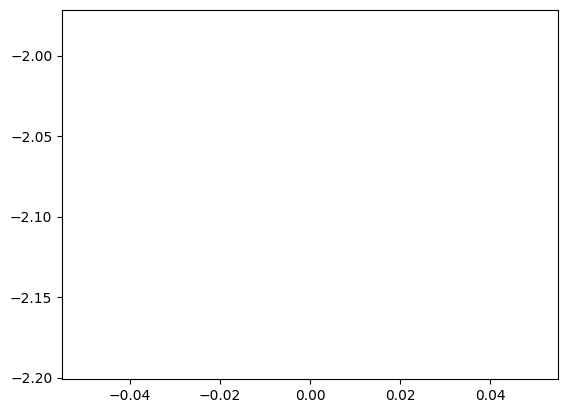

<Figure size 640x480 with 0 Axes>

In [7]:
with open(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}.hist', 'r') as hist:
    history = json.load(hist)
    
for key, values in history.items():
    plt.plot(values, label=key)
plt.show()
plt.savefig(f'{IMAGES_PATH}/{DATASET_NAME}/History/{MODEL_NAME}_History.png')
plt.clf()

In [8]:
train_label.shape

torch.Size([899, 1, 325])

## Predict on Train

100%|██████████| 175/175 [00:01<00:00, 97.71it/s] 


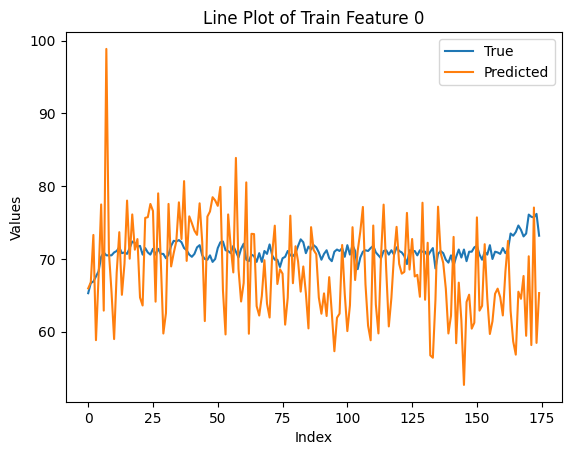

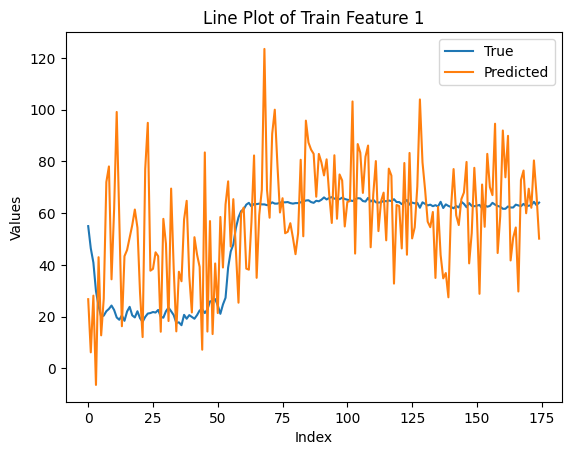

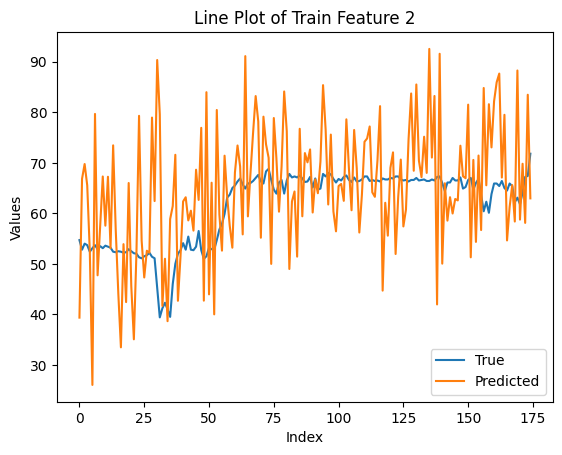

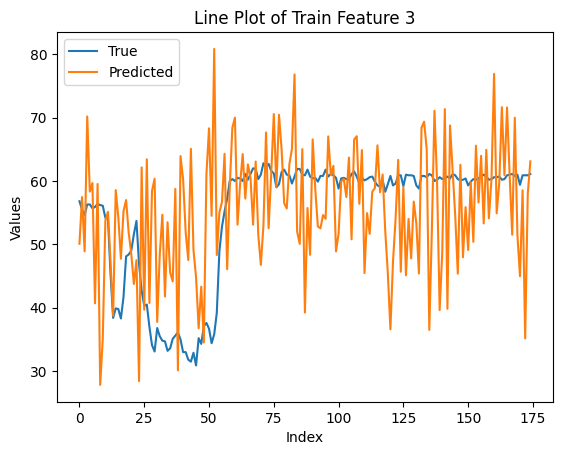

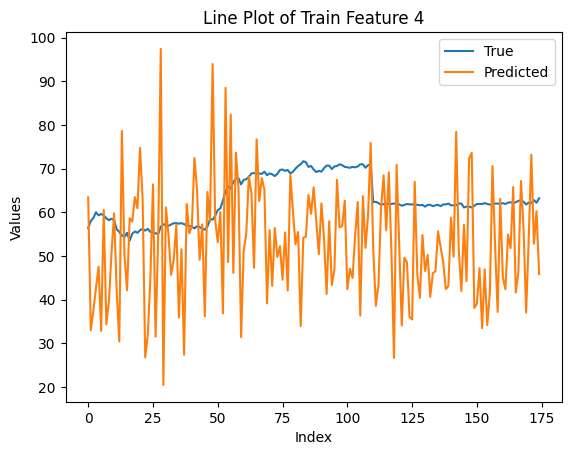

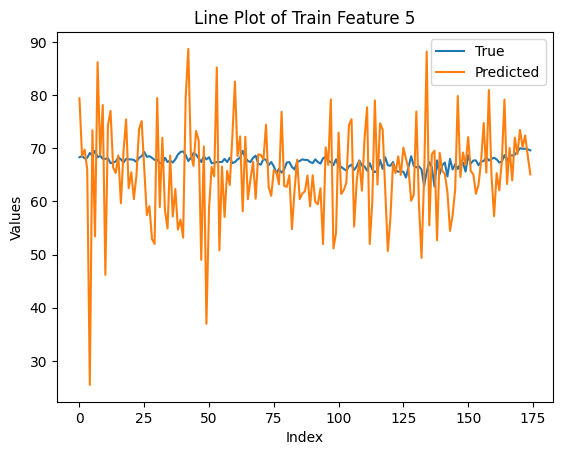

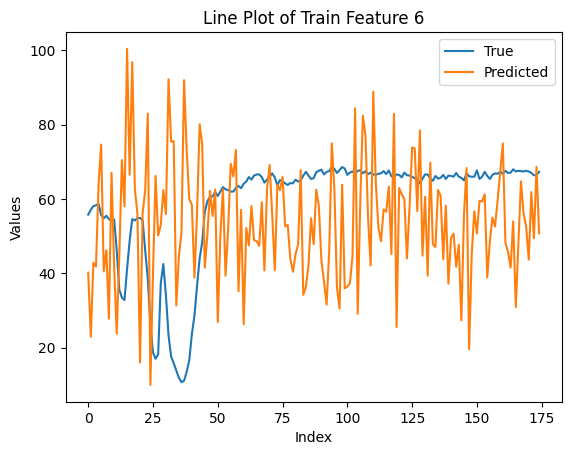

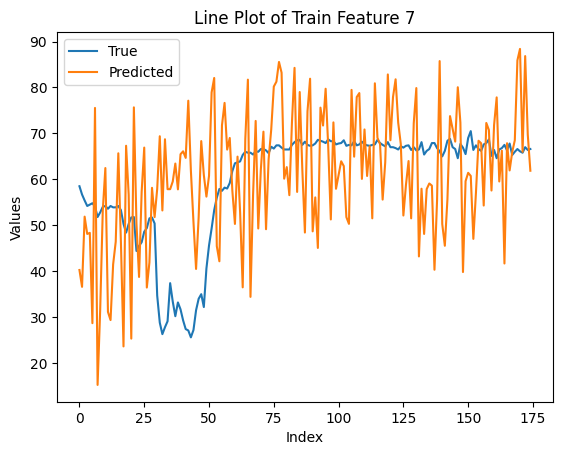

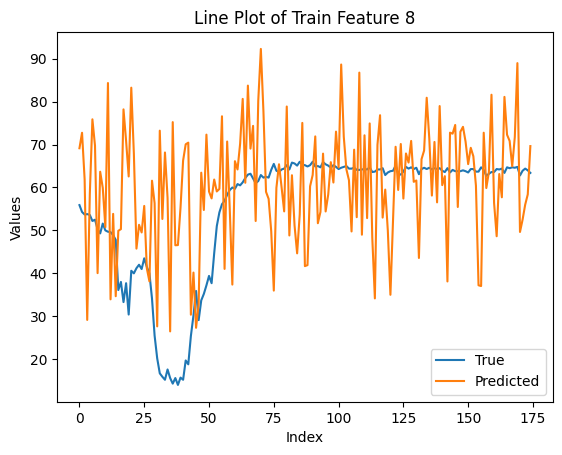

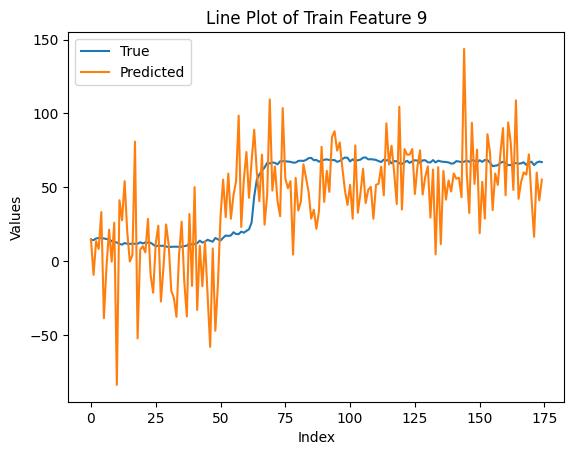

<Figure size 640x480 with 0 Axes>

In [12]:
SPLIT_NAME = 'Train'

# output = denormalize(model.predict_step(train_data, start=0, steps=50, mode='sum'))
output = model.predict_step(train_data, start=25, steps=175, mode='mean')

# data_true = denormalize(train_label[0:50, :, :].numpy())
data_true = train_label[25:200, :, :].numpy()
data_predicted = output.reshape(output.shape[0], output.shape[-1])
data_true = data_true.reshape(data_true.shape[0], data_true.shape[-1])

data_true = denormalize(data_true, name='PemsBay')
data_predicted = denormalize(data_predicted, name='PemsBay')
for i in range(10):
    first_elements_arr1 = [subarr[i] for subarr in data_true]
    first_elements_arr2 = [subarr[i] for subarr in data_predicted]
    # Plotting
    plt.plot(first_elements_arr1, label='True')
    plt.plot(first_elements_arr2, label='Predicted')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.title(f'Line Plot of Train Feature {i}')
    plt.legend()
    plt.show()
    plt.savefig(f'{IMAGES_PATH}/{DATASET_NAME}/{SPLIT_NAME}/{MODEL_NAME}_Feature_{i}.png')
    plt.clf()

## Generate on Train

100%|██████████| 175/175 [00:02<00:00, 83.67it/s]


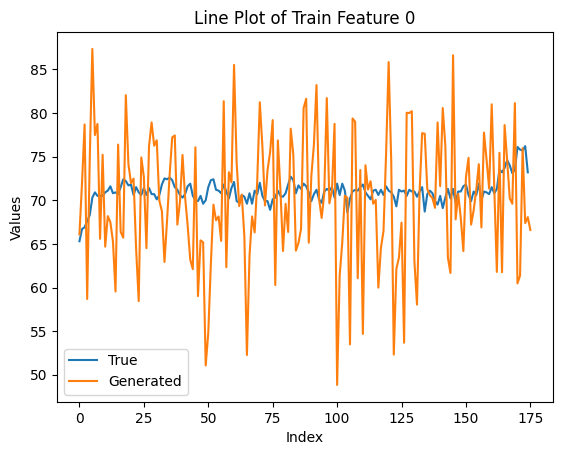

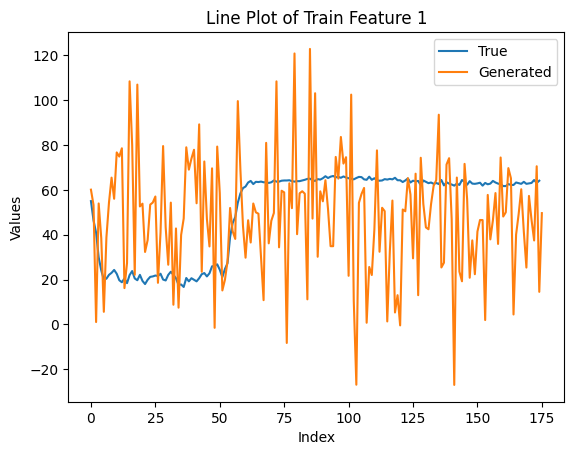

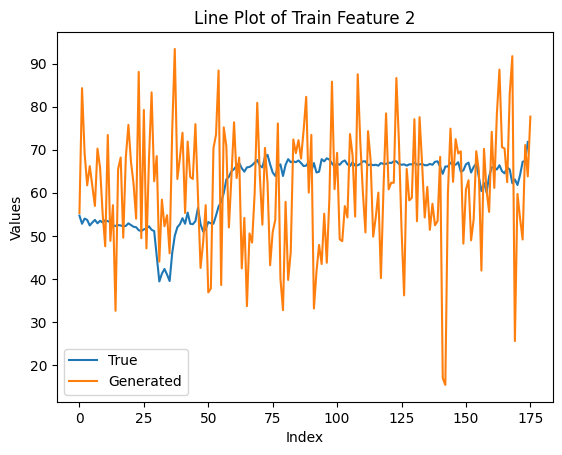

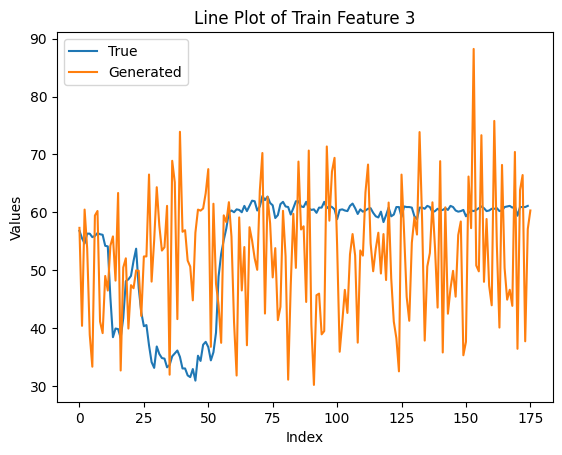

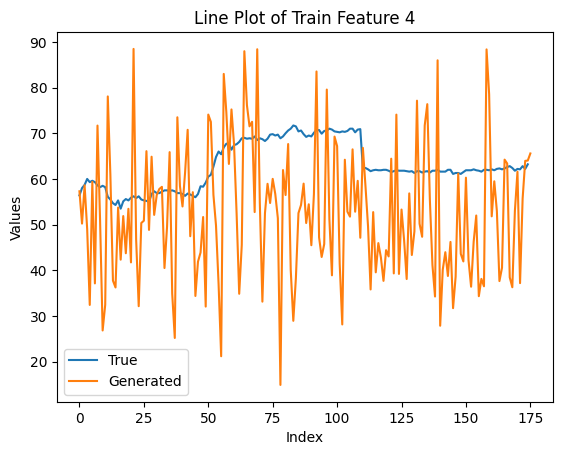

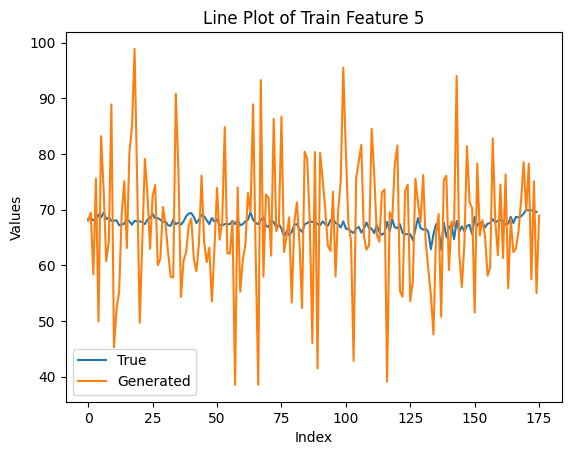

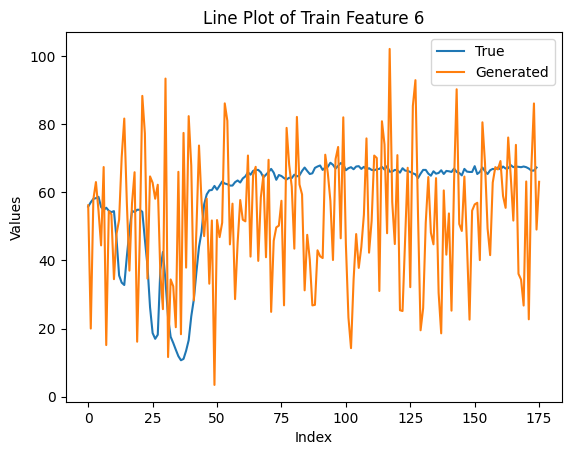

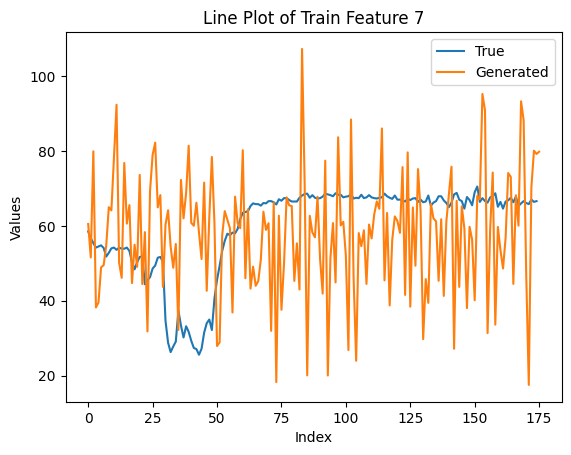

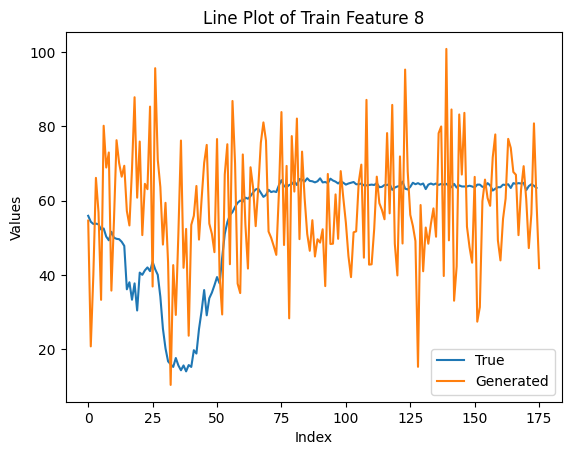

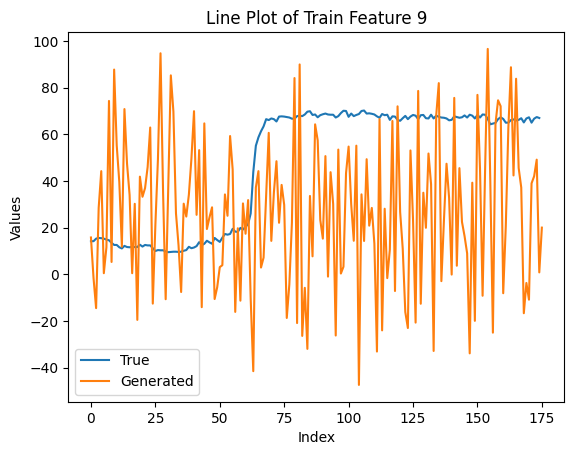

<Figure size 640x480 with 0 Axes>

In [13]:
# output = denormalize(model.generate_step(train_data, start=0, steps=200, mode='mean'))
output = model.generate_step(train_data, start=25, steps=175, mode='mean')

# data_true = denormalize(train_label[0:200, :, :].numpy())
data_true = train_label[25:200, :, :].numpy()
data_predicted = output.reshape(output.shape[0], output.shape[-1])
data_true = data_true.reshape(data_true.shape[0], data_true.shape[-1])

data_true = denormalize(data_true, name='PemsBay')
data_predicted = denormalize(data_predicted, name='PemsBay')
for i in range(10):
    first_elements_arr1 = [subarr[i] for subarr in data_true]
    first_elements_arr2 = [subarr[i] for subarr in data_predicted]
    # Plotting
    plt.plot(first_elements_arr1, label='True')
    plt.plot(first_elements_arr2, label='Generated')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.title(f'Line Plot of Train Feature {i}')
    plt.legend()
    plt.show()
    plt.savefig(f'{IMAGES_PATH}/{DATASET_NAME}/{SPLIT_NAME}/{MODEL_NAME}_Feature_{i}_GEN.png')
    plt.clf()

In [11]:

print(mmd_linear(data_true, data_predicted))  # 6.0
print(mmd_rbf(data_true, data_predicted))  # 0.5822
print(mmd_poly(data_true, data_predicted))  # 2436.5

75432110.0
0.011396104469895363
4848997107761152.0
